# Predicting the weather

In this notebook I'm attempting to predict the temperature for a station in the Netherlands, specifically at De Bilt. Data comes from https://projects.knmi.nl/klimatologie/uurgegevens/selectie.cgi and is freely available on the web. I took data from Jan 1, 2010 until Jan 4, 2020 on an hourly basis.

I will do the following:

- Look at the data first
- Try to predict the temperature in De Bilt without any features
- Try to predict the temperature in De Bilt with features
- Try to predict the temperature in multiple stations using shared features

The motivation behind this is a similar problem at work, I can't however use data as it's sensitive data (and I'm also not sure it will work), so I'm using this data to play around with.

In [254]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1. Getting the data

In [255]:
hourly_data = pd.read_csv("KNMI_20200104_hourly.txt",sep=",",header=0,skiprows=list(range(32))+[33],skipinitialspace=True)

In [256]:
hourly_data

,# STN,YYYYMMDD,HH,DD,FH,FF,FX,T,T10,TD,...,VV,N,U,WW,IX,M,R,S,O,Y
0,260,20100101,1,50,60,50,110,1,NaN,-38,...,66,8.0,75,NaN,5,0,0,0,0,0
1,260,20100101,2,40,60,50,110,1,NaN,-34,...,75,8.0,77,24.0,7,0,0,1,0,0
2,260,20100101,3,40,60,50,100,0,NaN,-35,...,75,8.0,77,77.0,7,0,0,1,0,0
3,260,20100101,4,30,50,40,100,-1,NaN,-37,...,74,8.0,74,24.0,7,0,0,1,0,0
4,260,20100101,5,30,50,50,90,-1,NaN,-38,...,75,8.0,73,NaN,5,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87739,260,20200104,20,270,30,30,60,74,NaN,63,...,43,8.0,93,10.0,7,0,0,0,0,0
87740,260,20200104,21,290,20,20,50,72,NaN,68,...,35,8.0,97,22.0,7,0,1,0,0,0
87741,260,20200104,22,290,20,20,40,72,NaN,69,...,35,8.0,98,52.0,7,0,1,0,0,0
87742,260,20200104,23,270,10,10,30,71,NaN,66,...,59,8.0,96,23.0,7,0,1,0,0,0


In [257]:
# Description
!head -n 35 KNMI_20200104_hourly.txt

# BRON: KONINKLIJK NEDERLANDS METEOROLOGISCH INSTITUUT (KNMI)
# Opmerking: door stationsverplaatsingen en veranderingen in waarneemmethodieken zijn deze tijdreeksen van uurwaarden mogelijk inhomogeen! Dat betekent dat deze reeks van gemeten waarden niet geschikt is voor trendanalyse. Voor studies naar klimaatverandering verwijzen we naar de gehomogeniseerde reeks maandtemperaturen van De Bilt <http://www.knmi.nl/klimatologie/onderzoeksgegevens/homogeen_260/index.html> of de Centraal Nederland Temperatuur <http://www.knmi.nl/klimatologie/onderzoeksgegevens/CNT/>.
# 
# 
# STN      LON(east)   LAT(north)     ALT(m)  NAME
# 260:         5.180       52.100       1.90  DE BILT
# 
# YYYYMMDD = datum (YYYY=jaar,MM=maand,DD=dag); 
# HH       = tijd (HH=uur, UT.12 UT=13 MET, 14 MEZT. Uurvak 05 loopt van 04.00 UT tot 5.00 UT; 
# DD       = Windrichting (in graden) gemiddeld over de laatste 10 minuten van het afgelopen uur (360=noord, 90=oost, 180=zuid, 270=west, 0=windstil 990=veranderlijk. Zie h

In [258]:
hourly_data.columns

Index(['# STN', 'YYYYMMDD', 'HH', 'DD', 'FH', 'FF', 'FX', 'T', 'T10', 'TD',
       'SQ', 'Q', 'DR', 'RH', 'P', 'VV', 'N', 'U', 'WW', 'IX', 'M', 'R', 'S',
       'O', 'Y'],
      dtype='object')

In [259]:
hourly_data

,# STN,YYYYMMDD,HH,DD,FH,FF,FX,T,T10,TD,...,VV,N,U,WW,IX,M,R,S,O,Y
0,260,20100101,1,50,60,50,110,1,NaN,-38,...,66,8.0,75,NaN,5,0,0,0,0,0
1,260,20100101,2,40,60,50,110,1,NaN,-34,...,75,8.0,77,24.0,7,0,0,1,0,0
2,260,20100101,3,40,60,50,100,0,NaN,-35,...,75,8.0,77,77.0,7,0,0,1,0,0
3,260,20100101,4,30,50,40,100,-1,NaN,-37,...,74,8.0,74,24.0,7,0,0,1,0,0
4,260,20100101,5,30,50,50,90,-1,NaN,-38,...,75,8.0,73,NaN,5,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87739,260,20200104,20,270,30,30,60,74,NaN,63,...,43,8.0,93,10.0,7,0,0,0,0,0
87740,260,20200104,21,290,20,20,50,72,NaN,68,...,35,8.0,97,22.0,7,0,1,0,0,0
87741,260,20200104,22,290,20,20,40,72,NaN,69,...,35,8.0,98,52.0,7,0,1,0,0,0
87742,260,20200104,23,270,10,10,30,71,NaN,66,...,59,8.0,96,23.0,7,0,1,0,0,0


In [260]:
hourly_data['HH'] = hourly_data['HH'] - 1
hourly_data['HH'] = hourly_data.HH.astype(str).str.pad(2,fillchar='0')

In [261]:
hourly_data.index = pd.to_datetime(hourly_data['YYYYMMDD'].astype(str) + ' ' + hourly_data['HH'],format='%Y%m%d %H')

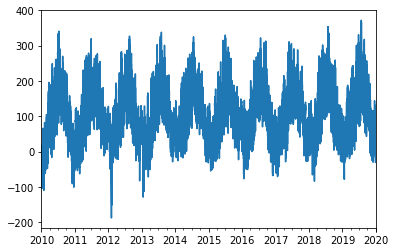

In [262]:
hourly_data['T'].plot()

In [263]:
hourly_data

,# STN,YYYYMMDD,HH,DD,FH,FF,FX,T,T10,TD,...,VV,N,U,WW,IX,M,R,S,O,Y
2010-01-01 00:00:00,260,20100101,00,50,60,50,110,1,NaN,-38,...,66,8.0,75,NaN,5,0,0,0,0,0
2010-01-01 01:00:00,260,20100101,01,40,60,50,110,1,NaN,-34,...,75,8.0,77,24.0,7,0,0,1,0,0
2010-01-01 02:00:00,260,20100101,02,40,60,50,100,0,NaN,-35,...,75,8.0,77,77.0,7,0,0,1,0,0
2010-01-01 03:00:00,260,20100101,03,30,50,40,100,-1,NaN,-37,...,74,8.0,74,24.0,7,0,0,1,0,0
2010-01-01 04:00:00,260,20100101,04,30,50,50,90,-1,NaN,-38,...,75,8.0,73,NaN,5,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-04 19:00:00,260,20200104,19,270,30,30,60,74,NaN,63,...,43,8.0,93,10.0,7,0,0,0,0,0
2020-01-04 20:00:00,260,20200104,20,290,20,20,50,72,NaN,68,...,35,8.0,97,22.0,7,0,1,0,0,0
2020-01-04 21:00:00,260,20200104,21,290,20,20,40,72,NaN,69,...,35,8.0,98,52.0,7,0,1,0,0,0
2020-01-04 22:00:00,260,20200104,22,270,10,10,30,71,NaN,66,...,59,8.0,96,23.0,7,0,1,0,0,0


# 2. Simple RNN, temperature only

In [373]:
# Represents the data as supervised data with a training window equal to history_size
# and a label equal to target_size
# freely taken from https://www.tensorflow.org/tutorials/structured_data/time_series
def univariate_data(dataset, start_index, end_index, history_size, target_size, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        if single_step:
            labels.append(dataset[i+target_size])
        else:
            labels.append(dataset[i:i+target_size])
    return np.array(data), np.array(labels)

In [374]:
hourly_data.shape[0]

87744

In [375]:
TRAIN_SIZE = 70000

In [376]:
temp_only_data = hourly_data['T']
temp_only_data.index = hourly_data.index.values
temp_only_data.head()

2010-01-01 00:00:00    1
2010-01-01 01:00:00    1
2010-01-01 02:00:00    0
2010-01-01 03:00:00   -1
2010-01-01 04:00:00   -1
Name: T, dtype: int64

In [377]:
# Normalisation
temp_only_data_train_mean = temp_only_data[:TRAIN_SIZE].mean()
temp_only_data_train_std = temp_only_data[:TRAIN_SIZE].std()

temp_only_data = (temp_only_data - temp_only_data_train_mean) / temp_only_data_train_std

temp_only_data = temp_only_data.values

In [378]:
temp_only_data

array([-1.54261948, -1.54261948, -1.55733677, ..., -0.49769159,
       -0.51240888, -0.51240888])

In [379]:
history_size = 7*24
target_size = 24

x_train, y_train = univariate_data(temp_only_data, 0, TRAIN_SIZE,
                                           history_size,
                                           target_size)
x_val, y_val = univariate_data(temp_only_data, TRAIN_SIZE, None,
                                       history_size,
                                       target_size)

In [380]:
print('Single window of past history')
print(x_train[0])
print('\n Target temperature to predict')
print(y_train[0])

Single window of past history
[[-1.54261948]
 [-1.54261948]
 [-1.55733677]
 [-1.57205407]
 [-1.57205407]
 [-1.58677136]
 [-1.63092325]
 [-1.66035783]
 [-1.57205407]
 [-1.58677136]
 [-1.54261948]
 [-1.57205407]
 [-1.4837503 ]
 [-1.4837503 ]
 [-1.55733677]
 [-1.67507513]
 [-1.89583454]
 [-2.02829019]
 [-2.14602854]
 [-2.08715937]
 [-2.27848419]
 [-2.36678796]
 [-2.45509172]
 [-2.48452631]
 [-2.42565714]
 [-2.38150525]
 [-2.2637669 ]
 [-2.08715937]
 [-2.05772478]
 [-2.07244207]
 [-1.89583454]
 [-1.88111725]
 [-1.76337889]
 [-1.64564054]
 [-1.58677136]
 [-1.54261948]
 [-1.4984676 ]
 [-1.43959842]
 [-1.42488113]
 [-1.42488113]
 [-1.42488113]
 [-1.41016383]
 [-1.41016383]
 [-1.45431571]
 [-1.42488113]
 [-1.42488113]
 [-1.63092325]
 [-1.77809619]
 [-1.88111725]
 [-1.93998643]
 [-2.13131125]
 [-2.23433231]
 [-2.30791878]
 [-2.38150525]
 [-2.35207066]
 [-2.42565714]
 [-2.05772478]
 [-1.98413831]
 [-1.91055184]
 [-1.85168266]
 [-1.77809619]
 [-1.71922701]
 [-1.82224807]
 [-2.02829019]
 [-2.30791

## Baseline (simple mean)

In [381]:
# Again credit to https://www.tensorflow.org/tutorials/structured_data/time_series
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

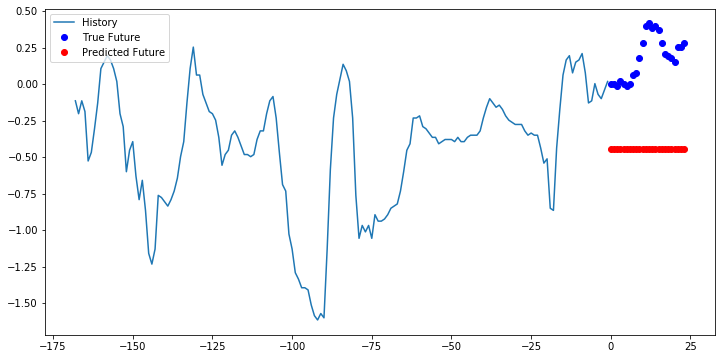

In [382]:
w = np.random.randint(0,x_train.shape[0])

multi_step_plot(x_train[w], y_train[w], np.mean(x_train[w]).repeat(len(y_train[w])))

In [390]:
x_val[:,-24:,:].shape

(17552, 24, 1)

In [393]:
# Base loss (mean of last week)

pd.DataFrame(y_val).subtract(x_val.mean(axis=1)).applymap(abs).apply(sum).sum() / (y_val.shape[0] * y_val.shape[1])

0.5006580202322999

In [391]:
# Base loss (mean of last day)

pd.DataFrame(y_val).subtract(x_val[:,-24:,:].mean(axis=1)).applymap(abs).apply(sum).sum() / (y_val.shape[0] * y_val.shape[1])

0.4321496841926311

# RNN

In [324]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val = val.batch(BATCH_SIZE).repeat()

In [335]:
simple_lstm_model = tf.keras.models.Sequential([
    
    tf.keras.layers.LSTM(32,return_sequences=True,input_shape=x_train.shape[-2:]),
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.Dense(target_size)
])

simple_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss='mae')

In [336]:
for x,y in val.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 24)


In [337]:
train

<RepeatDataset shapes: ((None, 168, 3), (None, 24)), types: (tf.float64, tf.float64)>

In [339]:
EVALUATION_INTERVAL = 200
EPOCHS = 15

records = simple_lstm_model.fit(train, epochs=EPOCHS, validation_data=val, steps_per_epoch=EVALUATION_INTERVAL, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/15
200/200 [==============================] - 44s 218ms/step - loss: 0.4845 - val_loss: 0.4420
Epoch 2/15
200/200 [==============================] - 43s 216ms/step - loss: 0.3777 - val_loss: 0.3803
Epoch 3/15
200/200 [==============================] - 43s 216ms/step - loss: 0.3248 - val_loss: 0.3289
Epoch 4/15
200/200 [==============================] - 43s 216ms/step - loss: 0.2956 - val_loss: 0.3116
Epoch 5/15
200/200 [==============================] - 43s 216ms/step - loss: 0.2846 - val_loss: 0.3022
Epoch 6/15
200/200 [==============================] - 43s 216ms/step - loss: 0.2813 - val_loss: 0.2973
Epoch 7/15
200/200 [==============================] - 43s 216ms/step - loss: 0.2760 - val_loss: 0.2944
Epoch 8/15
200/200 [==============================] - 43s 216ms/step - loss: 0.2730 - val_loss: 0.2909
Epoch 9/15
200/200 [==============================] - 43s 216ms/step - loss: 0.2693 - val_loss: 0.2907
Epoch 10/15
200/200 [=========

In [340]:
# Again credit to https://www.tensorflow.org/tutorials/structured_data/time_series
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

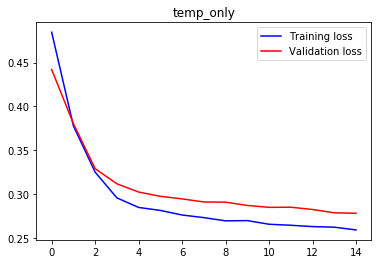

In [341]:
plot_train_history(records,'temp_only')

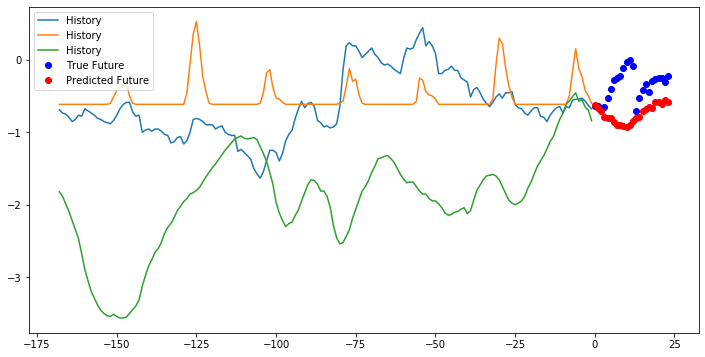

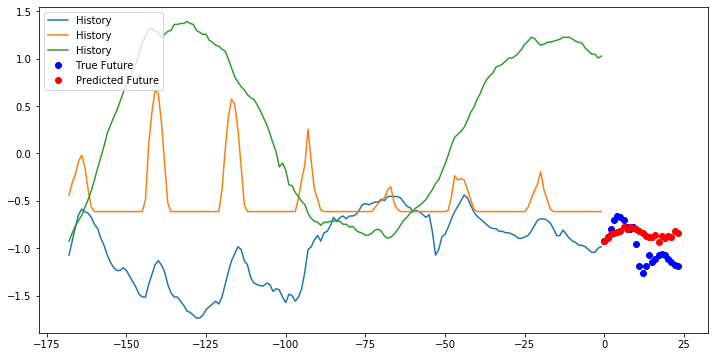

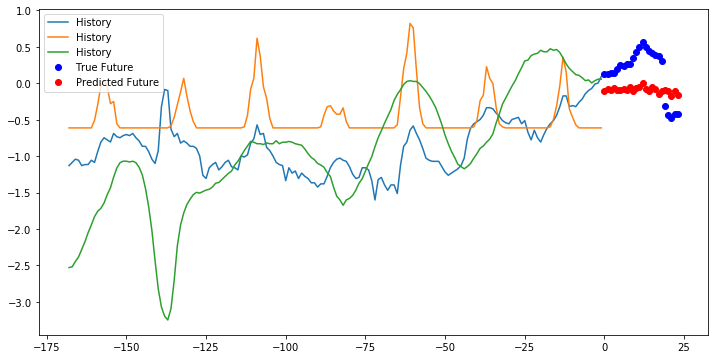

In [342]:
w = np.random.randint(0,x_train.shape[0])

for x,y in val.take(3):
    multi_step_plot(x[0], y[0], simple_lstm_model.predict(x)[0])

# 3. RNN with pressure (P)

In [394]:
# Represents the data as supervised data with a training window equal to history_size
# and a label equal to target_size
# freely taken from https://www.tensorflow.org/tutorials/structured_data/time_series
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [395]:
data = hourly_data[['T','P']]
data.index = hourly_data.index.values
data.head()

,T,P
2010-01-01 00:00:00,1,9981
2010-01-01 01:00:00,1,9979
2010-01-01 02:00:00,0,9978
2010-01-01 03:00:00,-1,9981
2010-01-01 04:00:00,-1,9985


In [396]:
data.tail()

,T,P
2020-01-04 19:00:00,74,10324
2020-01-04 20:00:00,72,10330
2020-01-04 21:00:00,72,10331
2020-01-04 22:00:00,71,10336
2020-01-04 23:00:00,71,10336


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4649baf9d0>,
      dtype=object)

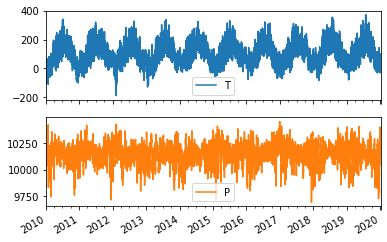

In [397]:
data.plot(subplots=True)

In [398]:
# Normalisation
data_train_mean = data[:TRAIN_SIZE].mean(axis=0)
data_train_std = data[:TRAIN_SIZE].std(axis=0)

data = (data - data_train_mean) / data_train_std

data = data.values

In [399]:
data

array([[-1.54261948, -1.80999595],
       [-1.54261948, -1.83084586],
       [-1.55733677, -1.84127082],
       ...,
       [-0.49769159,  1.83873875],
       [-0.51240888,  1.89086353],
       [-0.51240888,  1.89086353]])

In [400]:
type(data)

numpy.ndarray

In [401]:
history_size = 7*24
target_size = 24

x_train, y_train = multivariate_data(data, data[:,0], 0, TRAIN_SIZE,
                                           history_size,
                                           target_size)
x_val, y_val = multivariate_data(data, data[:,0], TRAIN_SIZE, None,
                                       history_size,
                                       target_size)

In [402]:
print ('Single window of past history : {}'.format(x_train[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train[0].shape))

Single window of past history : (168, 2)

 Target temperature to predict : (24,)


In [403]:
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val = val.batch(BATCH_SIZE).repeat()

In [404]:
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
lstm_model.add(tf.keras.layers.LSTM(16, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(target_size))

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss='mae')

In [405]:
lstm_model_records = lstm_model.fit(train, epochs=25,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/25
200/200 [==============================] - 46s 230ms/step - loss: 0.5946 - val_loss: 0.4723
Epoch 2/25
200/200 [==============================] - 43s 216ms/step - loss: 0.4009 - val_loss: 0.4231
Epoch 3/25
200/200 [==============================] - 43s 216ms/step - loss: 0.3769 - val_loss: 0.4006
Epoch 4/25
200/200 [==============================] - 43s 216ms/step - loss: 1.3182 - val_loss: 0.7184
Epoch 5/25
200/200 [==============================] - 43s 216ms/step - loss: 0.5679 - val_loss: 0.6171
Epoch 6/25
200/200 [==============================] - 43s 217ms/step - loss: 0.5018 - val_loss: 0.5717
Epoch 7/25
200/200 [==============================] - 43s 216ms/step - loss: 0.4597 - val_loss: 0.5514
Epoch 8/25
200/200 [==============================] - 43s 216ms/step - loss: 0.4541 - val_loss: 0.5388
Epoch 9/25
200/200 [==============================] - 43s 216ms/step - loss: 0.4409 - val_loss: 0.5283
Epoch 10/25
200/200 [=========

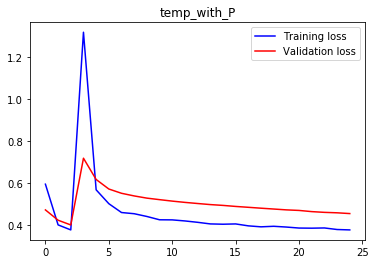

In [406]:
plot_train_history(lstm_model_records,'temp_with_P')

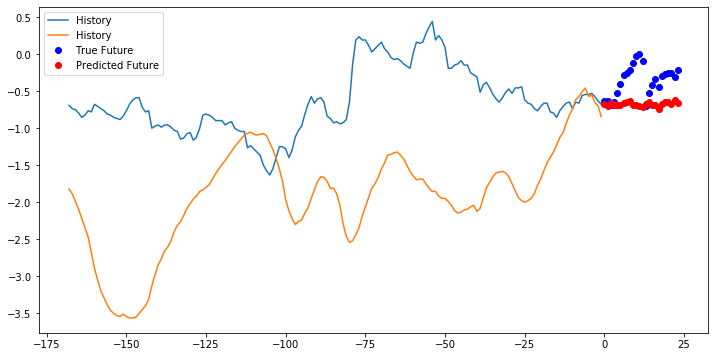

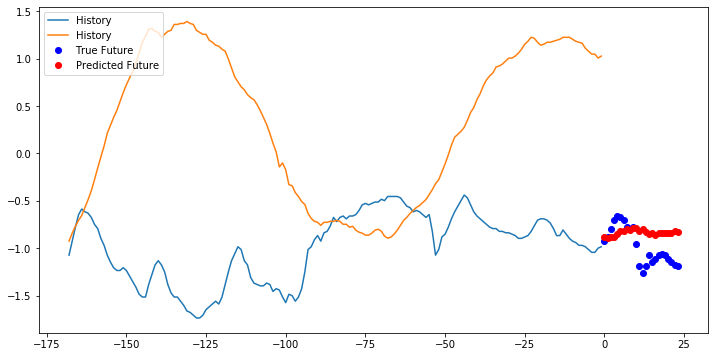

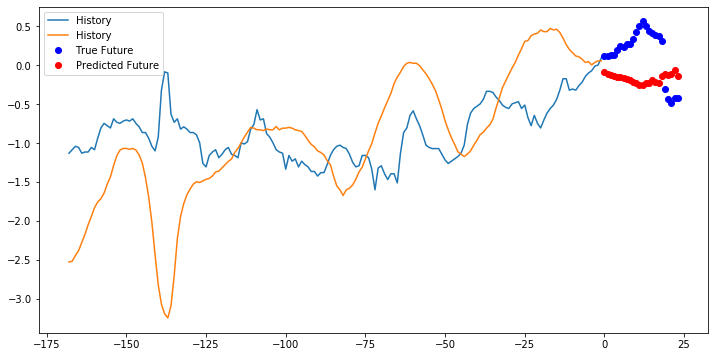

In [407]:
for x,y in val.take(3):
    multi_step_plot(x[0], y[0], lstm_model.predict(x)[0])

# 4. RNN with pressure (P) and solar radiation (Q)

In [408]:
data = hourly_data[['T','Q','P']]
data.index = hourly_data.index.values
data.head()

,T,Q,P
2010-01-01 00:00:00,1,0,9981
2010-01-01 01:00:00,1,0,9979
2010-01-01 02:00:00,0,0,9978
2010-01-01 03:00:00,-1,0,9981
2010-01-01 04:00:00,-1,0,9985


In [409]:
data.tail()

,T,Q,P
2020-01-04 19:00:00,74,0,10324
2020-01-04 20:00:00,72,0,10330
2020-01-04 21:00:00,72,0,10331
2020-01-04 22:00:00,71,0,10336
2020-01-04 23:00:00,71,0,10336


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f464de0e1d0>,
      dtype=object)

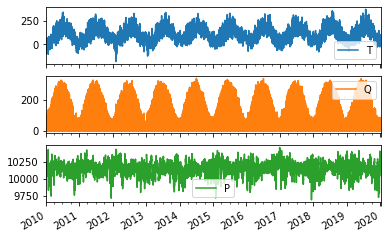

In [410]:
data.plot(subplots=True)

In [411]:
# Normalisation
data_train_mean = data[:TRAIN_SIZE].mean(axis=0)
data_train_std = data[:TRAIN_SIZE].std(axis=0)

data = (data - data_train_mean) / data_train_std

data = data.values

In [412]:
data

array([[-1.54261948, -0.6128305 , -1.80999595],
       [-1.54261948, -0.6128305 , -1.83084586],
       [-1.55733677, -0.6128305 , -1.84127082],
       ...,
       [-0.49769159, -0.6128305 ,  1.83873875],
       [-0.51240888, -0.6128305 ,  1.89086353],
       [-0.51240888, -0.6128305 ,  1.89086353]])

In [413]:
type(data)

numpy.ndarray

In [414]:
history_size = 7*24
target_size = 24

x_train, y_train = multivariate_data(data, data[:,0], 0, TRAIN_SIZE,
                                           history_size,
                                           target_size)
x_val, y_val = multivariate_data(data, data[:,0], TRAIN_SIZE, None,
                                       history_size,
                                       target_size)

In [415]:
print ('Single window of past history : {}'.format(x_train[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train[0].shape))

Single window of past history : (168, 3)

 Target temperature to predict : (24,)


In [416]:
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val = val.batch(BATCH_SIZE).repeat()

In [417]:
lstm_model = tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
lstm_model.add(tf.keras.layers.LSTM(16, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(target_size))

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss='mae')

In [418]:
lstm_model_records = lstm_model.fit(train, epochs=25,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/25
200/200 [==============================] - 48s 239ms/step - loss: 0.5975 - val_loss: 0.4479
Epoch 2/25
200/200 [==============================] - 43s 216ms/step - loss: 0.3835 - val_loss: 0.3942
Epoch 3/25
200/200 [==============================] - 43s 215ms/step - loss: 0.3368 - val_loss: 0.3431
Epoch 4/25
200/200 [==============================] - 43s 216ms/step - loss: 0.2939 - val_loss: 0.3045
Epoch 5/25
200/200 [==============================] - 43s 216ms/step - loss: 0.2752 - val_loss: 0.2930
Epoch 6/25
200/200 [==============================] - 43s 216ms/step - loss: 0.2708 - val_loss: 0.2896
Epoch 7/25
200/200 [==============================] - 43s 215ms/step - loss: 0.2654 - val_loss: 0.2848
Epoch 8/25
200/200 [==============================] - 43s 216ms/step - loss: 0.2633 - val_loss: 0.2813
Epoch 9/25
200/200 [==============================] - 44s 220ms/step - loss: 0.2595 - val_loss: 0.2819
Epoch 10/25
200/200 [=========

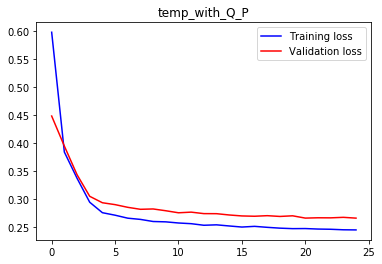

In [419]:
plot_train_history(lstm_model_records,'temp_with_Q_P')

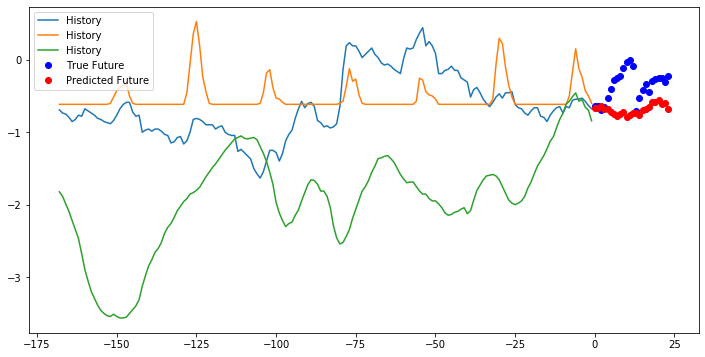

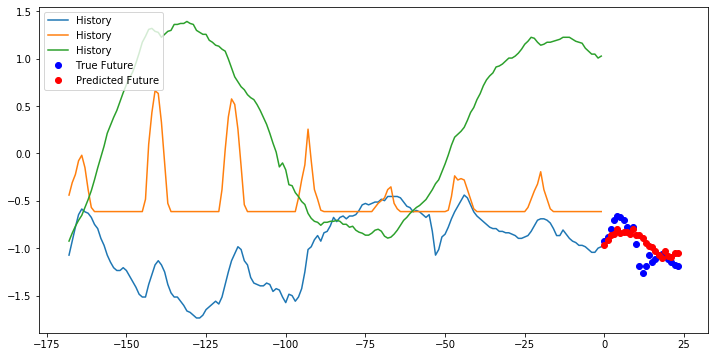

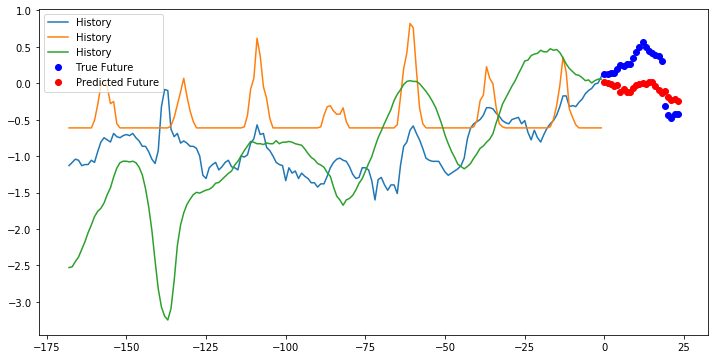

In [420]:
for x,y in val.take(3):
    multi_step_plot(x[0], y[0], lstm_model.predict(x)[0])